## FC

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data FC

In [3]:
df = pd.read_csv("new_data/kitabisa_review _FC.csv")
df.head()

content     FC
0  Aplikasi kitabisa bagus. Tpi yang diutamakan d...  False
1  Kalau memungkinkan  sebaiknya donasi gak terla...  False
2  Alhamdulillah sangat sangat membantu. Seneng b...   True
3  Assalamualaikum Sebelum terimakasih udah ada a...  False
4  Mau berdonasi dr kampanye d ig  tapi pas buka ...  False

In [4]:
df.FC.value_counts()

False    6479
True     1209
Name: FC, dtype: int64

In [5]:
df.FC.value_counts(normalize=True)

False    0.842742
True     0.157258
Name: FC, dtype: float64

### Encoding with W2V Model

In [6]:
from gensim.models import Word2Vec

In [7]:
w2v = Word2Vec.load("model/w2v/kitabisa_review.w2v").wv

In [8]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    
    
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [9]:
vecs.shape

(7688, 200)

### Dataset Splitting

In [10]:
X = vecs
y = df.FC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6150, 200), (1538, 200), (6150,), (1538,))

### SMOTE Data Modeling

In [11]:
from collections import Counter
print(Counter(y))

Counter({False: 6479, True: 1209})


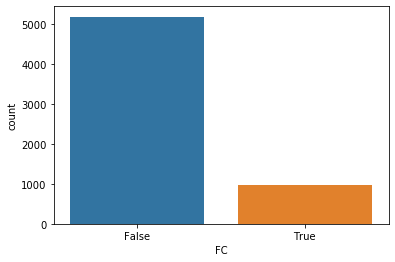

In [12]:
import seaborn as sns
sns.countplot(x=y_train)

Text(0, 0.5, 'X column False')

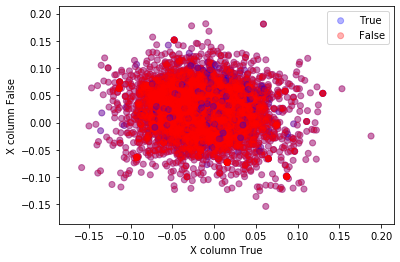

In [13]:
import matplotlib.pyplot as plt

for i, color in enumerate(['True', 'False']):
    plt.scatter(X[:, 0], X[:, 1], c=['b' if p == i else 'r' for p in y], alpha=0.3, label=color)
plt.legend()
plt.xlabel('X column True')
plt.ylabel('X column False')

In [14]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=13)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_res_test, y_res_test = sm.fit_resample(X_test, y_test)



print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Original dataset shape is  Counter({False: 5183, True: 967})
Resample dataset shape is  Counter({False: 5183, True: 5183})
Resample dataset test shape is  Counter({False: 1296, True: 1296})


In [15]:
print(Counter(y_res))

Counter({False: 5183, True: 5183})


### Training SVM

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [18]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits
{'algo__C': 10.0, 'algo__gamma': 10.0}
0.9999035307736832 0.9780065193999621 0.8603395061728395


### Evaluation

In [19]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

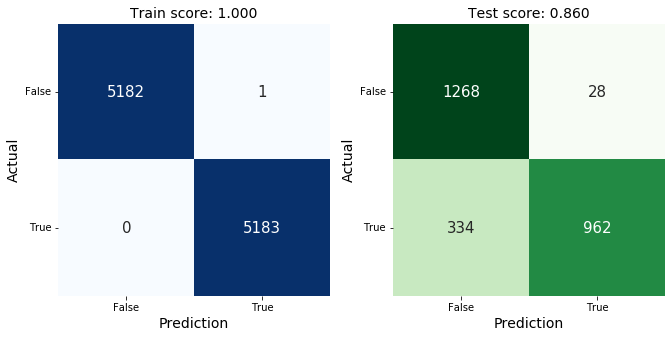

In [20]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [21]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5183
        True       1.00      1.00      1.00      5183

    accuracy                           1.00     10366
   macro avg       1.00      1.00      1.00     10366
weighted avg       1.00      1.00      1.00     10366


Test report
              precision    recall  f1-score   support

       False       0.79      0.98      0.88      1296
        True       0.97      0.74      0.84      1296

    accuracy                           0.86      2592
   macro avg       0.88      0.86      0.86      2592
weighted avg       0.88      0.86      0.86      2592



### Encoding with FastText

In [6]:
from gensim.models import FastText

In [7]:
fastText = FastText.load("model/fasttext/kitabisa_review.fasttext").wv

In [8]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, fastText, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [9]:
vecs.shape

(7688, 200)

### Dataset Splitting

In [10]:
X = vecs
y = df.FC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6150, 200), (1538, 200), (6150,), (1538,))

### SMOTE Data Modeling

In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [12]:
sm = SMOTE(random_state=13)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_res_test, y_res_test = sm.fit_resample(X_test, y_test)



print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Original dataset shape is  Counter({False: 5183, True: 967})
Resample dataset shape is  Counter({False: 5183, True: 5183})
Resample dataset test shape is  Counter({False: 1296, True: 1296})


In [13]:
print(Counter(y_res))

Counter({False: 5183, True: 5183})


### Training with SVM

In [17]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits
{'algo__C': 10.0, 'algo__gamma': 10.0}
0.9999035307736832 0.9768483113227567 0.8668981481481481


### Evaluation

In [18]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

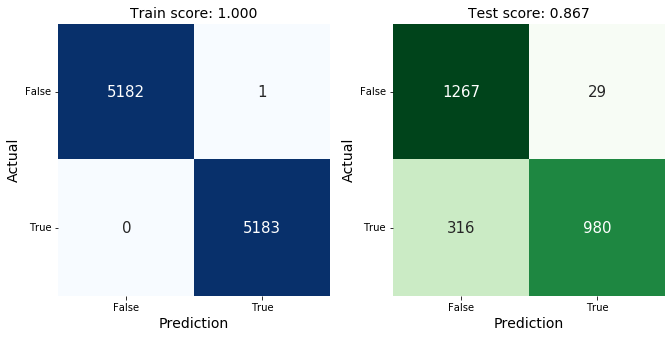

In [19]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [21]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5183
        True       1.00      1.00      1.00      5183

    accuracy                           1.00     10366
   macro avg       1.00      1.00      1.00     10366
weighted avg       1.00      1.00      1.00     10366


Test report
              precision    recall  f1-score   support

       False       0.80      0.98      0.88      1296
        True       0.97      0.76      0.85      1296

    accuracy                           0.87      2592
   macro avg       0.89      0.87      0.87      2592
weighted avg       0.89      0.87      0.87      2592

